<a href="https://colab.research.google.com/github/MannP7610/Speedbreaker-Potholes-detection-using-Efficientnet/blob/main/SbnPh2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

# Dataset paths
zip_path = '/content/drive/MyDrive/Pothole and Speed Breaker Dataset-400B.v3i.tensorflow.zip'
unzip_path = '/content/Pothole_SpeedBreaker_Dataset'

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

# Check dataset contents
print("Contents of the unzipped dataset directory:")
print(os.listdir(unzip_path))

Mounted at /content/drive
Contents of the unzipped dataset directory:
['train', 'valid', 'README.dataset.txt', 'README.roboflow.txt', 'test']


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2          # 20% for validation
)

# Training and validation data generators
train_generator = train_datagen.flow_from_directory(
    unzip_path,
    target_size=(224, 224),
    batch_size=32,  # Larger batch size for better gradient estimates
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    unzip_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 4403 images belonging to 3 classes.
Found 1100 images belonging to 3 classes.


In [ ]:
unique_classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_generator.classes
)
class_weights_dict = {class_label: weight for class_label, weight in zip(unique_classes, class_weights)}
print(f"Class Weights Dictionary: {class_weights_dict}")

Class Weights Dictionary: {0: 12.230555555555556, 1: 0.36691666666666667, 2: 5.186101295641932}


In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers[:-30]:
    layer.trainable = True  # Unfreeze more layers to fine-tune

# Build model architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # Increased fully connected layer size
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Patience increased for more epochs
    restore_best_weights=True
)

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,  # More epochs for better learning
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights_dict
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 1636s 11s/step - accuracy: 0.4733 - loss: 0.7433 - val_accuracy: 0.9090 - val_loss: 0.3112 - learning_rate: 1.0000e-04
Epoch 2/50
  1/137 ━━━━━━━━━━━━━━━━━━━━ 22:53 10s/step - accuracy: 0.5000 - loss: 0.1989

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5000 - loss: 0.1989 - val_accuracy: 0.9167 - val_loss: 0.2671 - learning_rate: 1.0000e-04
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1566s 11s/step - accuracy: 0.5288 - loss: 0.5414 - val_accuracy: 0.9081 - val_loss: 0.1521 - learning_rate: 1.0000e-04
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5312 - loss: 0.0580 - val_accuracy: 1.0000 - val_loss: 0.2087 - learning_rate: 1.0000e-04
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1573s 11s/step - accuracy: 0.5417 - loss: 0.3324 - val_accuracy: 0.9044 - val_loss: 0.0578 - learning_rate: 1.0000e-04
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5312 - loss: 0.4816 - val_accuracy: 0.8333 - val_loss: -0.3215 - learning_rate: 1.0000e-04
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 1556s 11s/step - accuracy: 0.5508 - loss: 0.0946 - val_accuracy: 0.8290 - val_loss: 0.1995 - learning_rate: 1.0000e-04
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 49s 289ms/step - accur

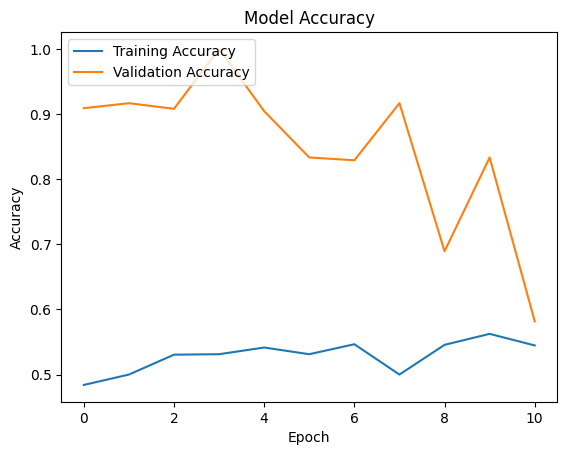

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

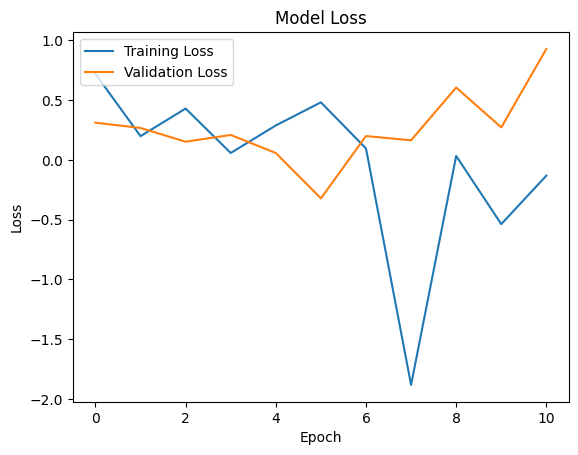

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9075 - loss: 0.0634
Validation Accuracy: 90.45%
Validation Loss: 0.0442
